# CZ gate coherent error benchmarking

In [2]:
import sys
sys.path.append('/Users/tport/miniconda3/envs/basic_scientific/lib/python3.13/site-packages')

import numpy as np

In [3]:
import numpy as np

folder = "Deterministic benchmarking result - modified"
n_cz = np.load(f"{folder}/num_cz_gates.npy");
pop_00 = np.load(f"{folder}/pop_00_vs_exp.npy");
pop_01 = np.load(f"{folder}/pop_01_vs_exp.npy");
pop_10 = np.load(f"{folder}/pop_10_vs_exp.npy");
pop_11 = np.load(f"{folder}/pop_11_vs_exp.npy");
pop_qb1 = np.load(f"{folder}/pop_QB1_vs_exp.npy");
pop_qb2 = np.load(f"{folder}/pop_QB2_vs_exp.npy");

In [4]:
data = pop_00 + pop_01 - pop_qb1;
print(np.max(data), np.min(data))
data = pop_00 + pop_10 - pop_qb1;
print(np.max(data), np.min(data))
data = pop_00 + pop_11 - pop_qb1;
print(np.max(data), np.min(data))
data = pop_01 + pop_10 - pop_qb1;
print(np.max(data), np.min(data))
data = pop_01 + pop_11 - pop_qb1;
print(np.max(data), np.min(data))
data = pop_10 + pop_11 - pop_qb1;
print(np.max(data), np.min(data))

0.9539999831467867 -0.7219999991357327
0.9539999831467867 -0.5209999829530716
0.9329999833134934 -0.6100000068545341
0.6199999861419201 -0.4829999804496765
0.7179999947547913 -0.6710000075399876
2.9802322387695312e-08 -2.9802322387695312e-08


The result of i-th experiment (entire circuit, with preparation and unpreparation) as stored as follows:

* `pop_00[i, t]` = P(00 measurement after evolving till t in i-th experiment)
* `pop_01[i, t]` = P(01 measurement after evolving till t in i-th experiment)
* `pop_10[i, t]` = P(10 measurement after evolving till t in i-th experiment)
* `pop_11[i, t]` = P(11 measurement after evolving till t in i-th experiment)
* `pop_qb1[i, t]` = P(1* measurement after evolving till t in i-th experiment)
* `pop_qb2[i, t]` = P(*1 measurement after evolving till t in i-th experiment)

In [211]:
class Exp():
    NO_DD_00 = 0
    NO_DD_11 = 1
    DD_PP = 2
    DD_P0 = 3
    DD_0P = 4
    PP = 5

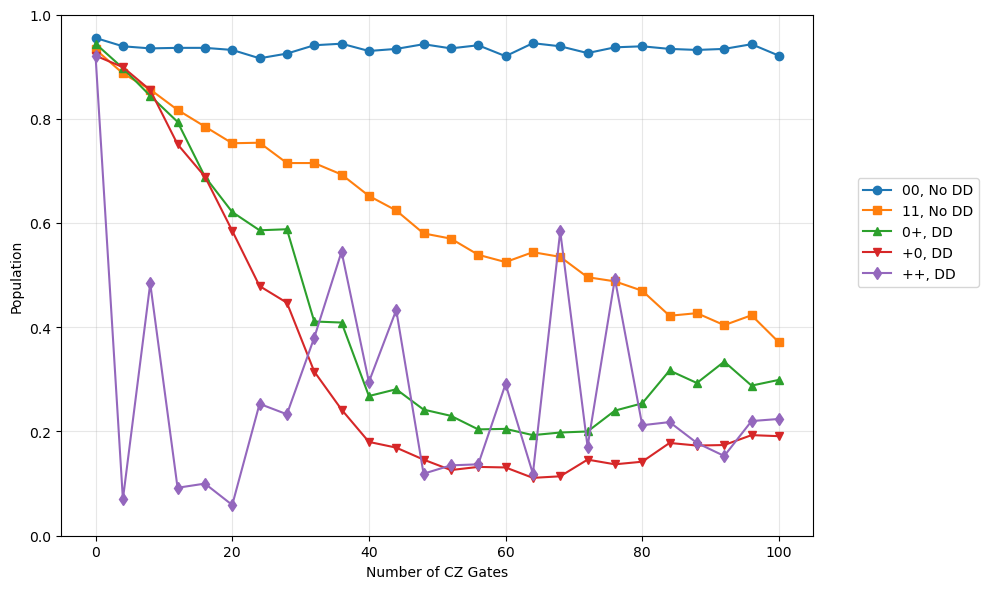

In [6]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(n_cz, pop_00[Exp.NO_DD_00,:], marker='o', label='00, No DD')
plt.plot(n_cz, pop_00[Exp.NO_DD_11,:], marker='s', label='11, No DD')
plt.plot(n_cz, pop_00[Exp.DD_0P,:], marker='^', label='0+, DD')
plt.plot(n_cz, pop_00[Exp.DD_P0,:], marker='v', label='+0, DD')
plt.plot(n_cz, pop_00[Exp.DD_PP,:], marker='d', label='++, DD')
plt.xlabel('Number of CZ Gates')
plt.ylabel('Population')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 0.7), loc='upper left')
plt.tight_layout()
plt.show()

Copy the formulas for fidelities based on open system modelling

In [214]:
T1_1 = 50; # microseconds
T1_2 = 25; # microseconds
T2_1 = 40; # microseconds
T2_2 = 4; # microseconds

tg_X = 0.030 + 0.010; # microseconds
tg_cz = 0.070 + 0.010; # microseconds

def ideal_curve_for_11(n, evolution_time, device_characteristics : dict, error_characteristics : dict):
    decay_factor = np.exp(-evolution_time/device_characteristics["T1_1"]);
    decay_factor = decay_factor * np.exp(-evolution_time/device_characteristics["T1_2"]);
    decay_factor = decay_factor ** (4 * n)
    return decay_factor;

def ideal_curve_for_0P(n, evolution_time, device_characteristics : dict, error_characteristics : dict):
    decay_factor = (np.exp(-evolution_time/device_characteristics["T2_2"])) ** (4 * n);
    return 0.5 * (1 + np.cos(8 * (error_characteristics["ZZ"] + error_characteristics["IZ"]) * n) * decay_factor);

def ideal_curve_for_P0(n, evolution_time, device_characteristics : dict, error_characteristics : dict):
    decay_factor = (np.exp(-evolution_time/device_characteristics["T2_1"])) ** (4 * n);
    return 0.5 * (1 + np.cos(8 * (error_characteristics["ZZ"] + error_characteristics["ZI"]) * n) * decay_factor);

def ideal_curve_for_PP(n, evolution_time, device_characteristics : dict, error_characteristics : dict):
    d1 = (np.exp(-evolution_time/device_characteristics["T2_1"])) ** (4);
    d2 = (np.exp(-evolution_time/device_characteristics["T2_2"])) ** (4);
    r1 = (np.exp(-evolution_time/device_characteristics["T1_1"])) ** (4);
    r2 = (np.exp(-evolution_time/device_characteristics["T1_2"])) ** (4);
    
    eps = error_characteristics["ZI"];
    kap = error_characteristics["IZ"];
    eta = error_characteristics["ZZ"];
    
    return 1/16 * (4 + 
        2 * (d1 ** n) * np.cos(8 * (eps + eta) * n) + 
        2 * (d2 ** n) * np.cos(8 * (kap + eta) * n) + 
        2 * (d1 ** n) * (d2 ** n) * np.cos(8 * (eps - kap) * n) + 
        2 * (d1 ** n) * (d2 ** n) * np.cos(8 * (eps + kap) * n) +
        2 * (d2 ** n) * (r1 ** n) * np.cos(8 * (eta - kap) * n) +
        2 * (d1 ** n) * (r2 ** n) * np.cos(8 * (eta - eps) * n) + 
        2 * np.real((-1 + r1) * (d2 ** n) * (np.exp(8j * (eta + kap) * n) *  - np.exp(-8j * (eta - kap) * n) * (r1 ** n)) / (np.exp(4j * eta) + r1)) +
        2 * np.real((-1 + r2) * (d1 ** n) * (np.exp(8j * (eta + eps) * n) *  - np.exp(-8j * (eta - eps) * n) * (r2 ** n)) / (np.exp(4j * eta) + r2))
        )

In [215]:
def ideal_curve_for_11(n, evolution_time, **kwargs):
    decay_factor = np.exp(-evolution_time/kwargs["T1_1"]);
    decay_factor = decay_factor + np.exp(-evolution_time/kwargs["T1_2"]);
    decay_factor = decay_factor ** (4 * n)
    return decay_factor;

y_data = ideal_curve_for_11(n_cz, 1, T1_1= 500, T2_2=300)
params, _, _ = fit_parameters_scipy_minimize(
    ideal_curve_for_11, n_cz, y_data, (400, 400),
    bounds = [timescale_bound, timescale_bound]);

KeyError: 'T1_2'

Define fitting functions which display the same behavior as the open system model but have free parameters

In [209]:
def fit_curve_for_No_DD_11(n, decay_timescale, infinite_time_spam, zero_time_spam):
    # spam variables lie between 0 and 1
    # (A + B * e^(-4 * n * t / T_D)
    device_characteristics = {
        "T1_1": decay_timescale,
        "T1_2": np.inf,
        "T2_1": np.inf,
        "T2_2": np.inf
    };
    error_characteristics = {"ZZ": 0, "ZI": 0, "IZ": 0}
    ideal_fidelity = ideal_curve_for_No_DD_11(n, 1, device_characteristics, error_characteristics);
    return infinite_time_spam + zero_time_spam * (ideal_fidelity - 0.5) / 0.5;

def fit_curve_for_DD_0P(n, decay_timescale, overrotation, infinite_time_spam, zero_time_spam):
    # spam variables lie between 0 and 1
    # (A + B * e^(-4 * n * t / T_D) * Cos(8 * n * theta))/2
    device_characteristics = {
        "T1_1": np.inf,
        "T1_2": np.inf,
        "T2_1": np.inf,
        "T2_2": decay_timescale
    };
    error_characteristics = {"ZZ": -np.pi/4, "ZI": -np.pi/4, "IZ": overrotation}
    ideal_fidelity = ideal_curve_for_0P(n, 1, device_characteristics, error_characteristics);
    return infinite_time_spam + zero_time_spam * (ideal_fidelity - 0.5) / 0.5;

def fit_curve_for_DD_P0(n, decay_timescale, overrotation, infinite_time_spam, zero_time_spam):
    # spam variables lie between 0 and 1
    # (A + B * e^(-4 * n * t / T_D) * Cos(8 * n * theta))/2
    device_characteristics = {
        "T1_1": np.inf,
        "T1_2": np.inf,
        "T2_1": decay_timescale,
        "T2_2": np.inf
    };
    error_characteristics = {"ZZ": -np.pi/4, "ZI": overrotation, "IZ": -np.pi/4}
    ideal_fidelity = ideal_curve_for_P0(n, 1, device_characteristics, error_characteristics);
    return infinite_time_spam + zero_time_spam * (ideal_fidelity - 0.5) / 0.5;

def fit_curve_for_PP(n, zz, zi, iz, infinite_time_spam, zero_time_spam, T1_1, T1_2, T2_1, T2_2):
    # spam variables lie between 0 and 1
    # ideal zero_time_spam = 1/16, infinite_time_spam = 4/16
    device_characteristics = {"T1_1": T1_1, "T1_2": T1_2, "T2_1": T2_1, "T2_2": T2_2};
    error_characteristics = {"ZZ": zz, "ZI": zi, "IZ": iz}
    ideal_fidelity = ideal_curve_for_PP(n, 1, device_characteristics, error_characteristics);
    return infinite_time_spam + zero_time_spam * (ideal_fidelity - 4 / 16) * 16;

def fit_curve_for_DD_PP(n, eta, infinite_time_spam, zero_time_spam, T1_1, T1_2, T2_1, T2_2):
    # spam variables lie between 0 and 1
    # ideal zero_time_spam = 1/16, infinite_time_spam = 4/16
    return fit_curve_for_PP(
        n, eta,  -np.pi/4,  -np.pi/4, infinite_time_spam, zero_time_spam, T1_1, T1_2, T2_1, T2_2);

def fit_curve_for_DD_PP_device_factory(tg_X, tg_cz, device_characteristics):
    # spam variables lie between 0 and 1
    # ideal zero_time_spam = 1/16, infinite_time_spam = 4/16
    def fit_function(n, eta, infinite_time_spam, zero_time_spam):
        tg = tg_X + tg_cz;
        T1_1 = device_characteristics["T1_1"] / tg;
        T1_2 = device_characteristics["T1_2"] / tg;
        T2_1 = device_characteristics["T2_1"] / tg;
        T2_2 = device_characteristics["T2_2"] / tg;
        return fit_curve_for_DD_PP(n, eta, infinite_time_spam, zero_time_spam, T1_1, T1_2, T2_1, T2_2);
    return fit_function;

Check the behavior of the different fitting routines to see which one performs the best. Check the fidelity with |0+⟩ first.

In [151]:
from parameter_optimization import fit_parameters_scipy_minimize
from parameter_optimization import fit_parameters_curve_fit
from parameter_optimization import fit_parameters_global_optimization
from parameter_optimization import fit_parameters_least_squares

In [175]:
angle_bound = (-0.1, 0.1); # radians
timescale_bound = (10, 1000);
spam_bound = (0, 1);

optim_params_minimize, y, _ = fit_parameters_scipy_minimize(
    fit_curve_for_DD_0P, n_cz, pop_00[Exp.DD_0P, :], (230, -0.1, 1, 1),
    bounds = [timescale_bound, angle_bound, spam_bound, spam_bound]);
optim_y = fit_curve_for_DD_0P(n_cz, *optim_params_minimize);
print("\nError from `minimize`:", np.sum(np.abs(optim_y - pop_00[Exp.DD_0P, :]) ** 2))
print("Timescale", optim_params_minimize[0])
print("Overrotation", optim_params_minimize[1])

optim_params_curve, y, yy = fit_parameters_curve_fit(
    fit_curve_for_DD_0P, n_cz, pop_00[Exp.DD_0P, :], (230, -0.1, 1, 1),
    bounds = [timescale_bound, angle_bound, spam_bound, spam_bound]);
optim_y = fit_curve_for_DD_0P(n_cz, *optim_params_curve);
print("\nError from `curve`:", np.sum(np.abs(optim_y - pop_00[Exp.DD_0P, :]) ** 2))
print("Timescale", optim_params_curve[0])
print("Overrotation", optim_params_curve[1])

optim_params_global, y, yy = fit_parameters_global_optimization(
    fit_curve_for_DD_0P, n_cz, pop_00[Exp.DD_0P, :],
    bounds = [timescale_bound, angle_bound, spam_bound, spam_bound]);
optim_y = fit_curve_for_DD_0P(n_cz, *optim_params_global);
print("\nError from `global`:", np.sum(np.abs(optim_y - pop_00[Exp.DD_0P, :]) ** 2))
print("Timescale", optim_params_global[0])
print("Overrotation", optim_params_global[1])

optim_params_squares, y, yy = fit_parameters_least_squares(
    fit_curve_for_DD_0P, n_cz, pop_00[Exp.DD_0P, :], (230, -0.1, 1, 1),
    bounds = [timescale_bound, angle_bound, spam_bound, spam_bound]);
optim_y = fit_curve_for_DD_0P(n_cz, *optim_params_squares);
print("\nError from `least_squares`:", np.sum(np.abs(optim_y - pop_00[Exp.DD_0P, :]) ** 2))
print("Timescale", optim_params_squares[0])
print("Overrotation", optim_params_squares[1])


Error from `minimize`: 1.4641225114528136
Timescale 229.99885961804216
Overrotation -0.1

Error from `curve`: 1.2734253744969322
Timescale 10.000000000000002
Overrotation -0.09999999999999999

Error from `global`: 0.02265144795832111
Timescale 232.8850726495295
Overrotation 0.0054608486363188985

Error from `least_squares`: 1.2734253744969322
Timescale 10.000000000000002
Overrotation -0.09999999999999999


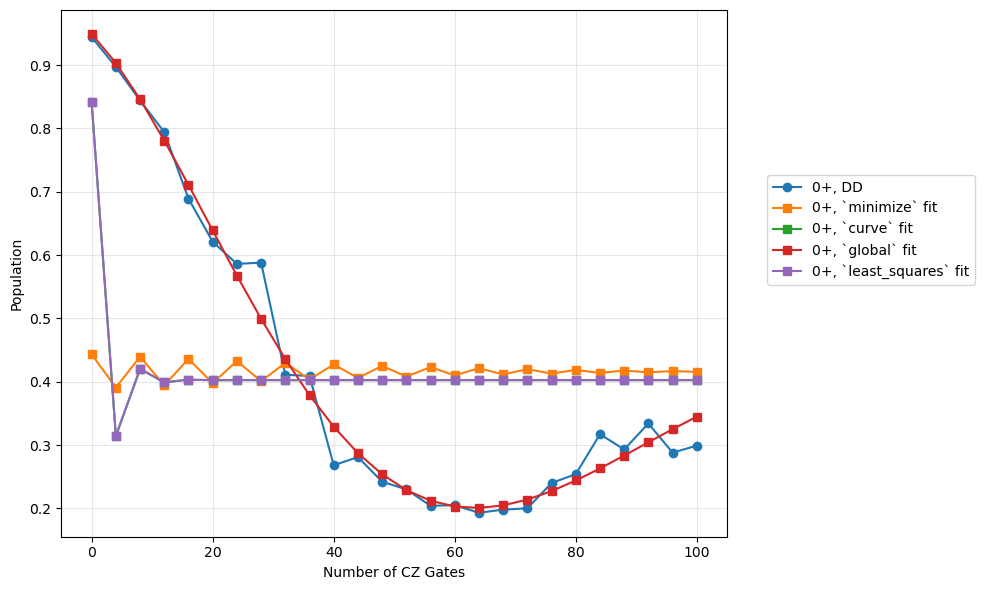

In [176]:
plt.figure(figsize=(10, 6))
plt.plot(n_cz, pop_00[Exp.DD_0P,:], marker='o', label='0+, DD')
plt.plot(n_cz, fit_curve_for_DD_0P(n_cz, *optim_params_minimize), marker='s', label='0+, `minimize` fit')
if optim_params_curve is not None:
    plt.plot(n_cz, fit_curve_for_DD_0P(n_cz, *optim_params_curve), marker='s', label='0+, `curve` fit')
plt.plot(n_cz, fit_curve_for_DD_0P(n_cz, *optim_params_global), marker='s', label='0+, `global` fit')
plt.plot(n_cz, fit_curve_for_DD_0P(n_cz, *optim_params_squares), marker='s', label='0+, `least_squares` fit')
plt.xlabel('Number of CZ Gates')
plt.ylabel('Population')
# plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 0.7), loc='upper left')
plt.tight_layout()
plt.show()


`least_squares` and `minimize` both are horrendous. But `minimize` changes a lot depending on the initial guess.

Error with initial T_D = 100, rotation = -0.1: 1.4520424115843897
Params: (np.float64(99.99657681527215), np.float64(-0.1))

Error with initial T_D = 100, rotation = 0: 0.09308753068204743
Params: (np.float64(99.99853263126373), np.float64(0.003917296028733766))

Error with initial T_D = 100, rotation = 0.1: 1.4520424115898736
Params: (np.float64(99.99657683729194), np.float64(0.1))

Error with initial T_D = 200, rotation = -0.1: 1.4630137548838427
Params: (np.float64(199.9980774422247), np.float64(-0.1))

Error with initial T_D = 200, rotation = 0: 0.02453489439856897
Params: (np.float64(199.9991431306938), np.float64(-0.005355803339660348))

Error with initial T_D = 200, rotation = 0.1: 1.4630137548860644
Params: (np.float64(199.99807749355946), np.float64(0.1))

Error with initial T_D = 300, rotation = -0.1: 1.4656326739829197
Params: (np.float64(299.9992463266315), np.float64(-0.1))

Error with initial T_D = 300, rotation = 0: 0.026663476170602787
Params: (np.float64(299.9992789989

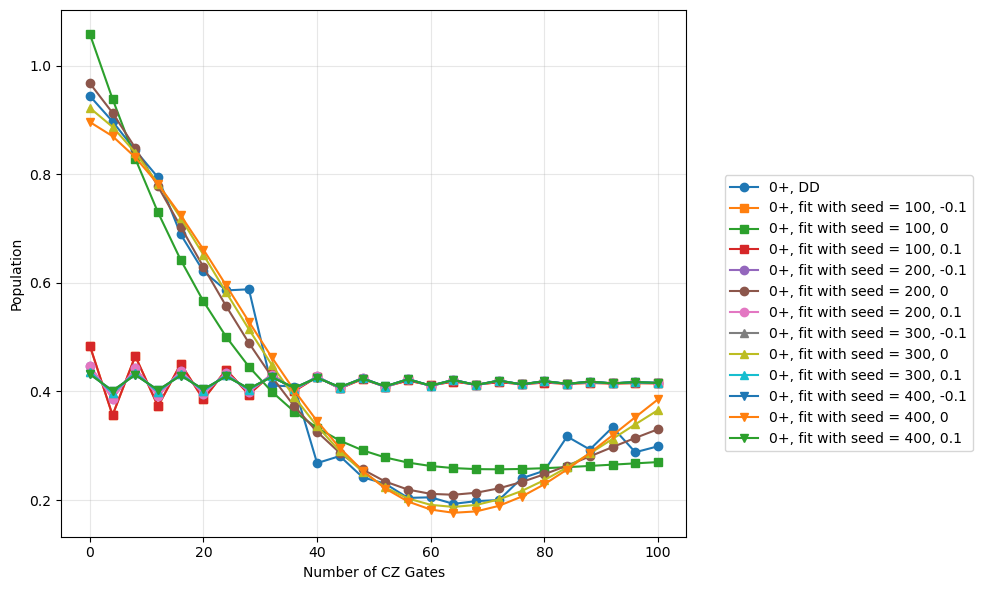

In [182]:
plt.figure(figsize=(10, 6))
plt.plot(n_cz, pop_00[Exp.DD_0P,:], marker='o', label='0+, DD')

marker = ['s', 'o', '^', 'v'];

for idx, time_seed in enumerate([100, 200, 300, 400]):
    for rotation_seed in [-0.1, 0, 0.1]:
        optim_params_minimize, y, yy = fit_parameters_scipy_minimize(
            fit_curve_for_DD_0P, n_cz, pop_00[Exp.DD_0P, :], (time_seed, rotation_seed, 1, 1),
            bounds = [timescale_bound, angle_bound, spam_bound, spam_bound]);
        optim_y = fit_curve_for_DD_0P(n_cz, *optim_params_minimize);
        error = np.sum(np.abs(optim_y - pop_00[Exp.DD_0P, :]) ** 2);

        print(f"Error with initial T_D = {time_seed}, rotation = {rotation_seed}: {error}")
        print(f"Params: {optim_params_minimize[0], optim_params_minimize[1]}")
        print()
        plt.plot(n_cz, fit_curve_for_DD_0P(n_cz, *optim_params_minimize), marker=marker[idx],
            label=f'0+, fit with seed = {time_seed}, {rotation_seed}')

plt.xlabel('Number of CZ Gates')
plt.ylabel('Population')
# plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 0.7), loc='upper left')
plt.tight_layout()
plt.show()

For |0+> then, the RMSE depends on a lot on the angle and not on the decay timescale. The initialization as well plays a major role in whether we are able to converge to the right angle.

Check results for the |++> state

In [ ]:
device_characteristics = {"T1_1": T1_1, "T1_2": T1_2, "T2_1": T2_1, "T2_2": T2_2};
fit_curve_for_DD_PP_with_device_timescales = fit_curve_for_DD_PP_device_factory(tg_X, tg_cz, device_characteristics);

angle_bound = (-0.1, 0.1); # radians
timescale_bound = (10, 1000);
spam_bound = (0, 1);

optim_params_minimize, y, yy = fit_parameters_scipy_minimize(
    fit_curve_for_DD_PP_with_device_timescales, n_cz, pop_00[Exp.DD_PP, :], (0.01, 4/16, 1/16),
    bounds = [angle_bound, spam_bound, spam_bound]);
optim_y = fit_curve_for_DD_PP_with_device_timescales(n_cz, *optim_params_minimize);
print("\nError from `minimize`:", np.sum(np.abs(optim_y - pop_00[Exp.DD_PP, :]) ** 2))
print("Overrotation", optim_params_global[0])

optim_params_curve, y, yy = fit_parameters_curve_fit(
    fit_curve_for_DD_PP_with_device_timescales, n_cz, pop_00[Exp.DD_PP, :], (0.01, 4/16, 1/16),
    bounds = [angle_bound, spam_bound, spam_bound]);
optim_y = fit_curve_for_DD_PP_with_device_timescales(n_cz, *optim_params_curve);
print("\nError from `curve`:", np.sum(np.abs(optim_y - pop_00[Exp.DD_PP, :]) ** 2))
print("Overrotation", optim_params_global[0])

optim_params_global, y, yy = fit_parameters_global_optimization(
    fit_curve_for_DD_PP_with_device_timescales, n_cz, pop_00[Exp.DD_PP, :],
    bounds = [angle_bound, spam_bound, spam_bound]);
optim_y = fit_curve_for_DD_PP_with_device_timescales(n_cz, *optim_params_global);
print("\nError from `global`:", np.sum(np.abs(optim_y - pop_00[Exp.DD_PP, :]) ** 2))
print("Overrotation", optim_params_global[0])

optim_params_squares, y, yy = fit_parameters_least_squares(
    fit_curve_for_DD_PP_with_device_timescales, n_cz, pop_00[Exp.DD_PP, :], (0.01, 4/16, 1/16),
    bounds = [angle_bound, spam_bound, spam_bound]);
optim_y = fit_curve_for_DD_PP_with_device_timescales(n_cz, *optim_params_squares);
print("\nError from `least_squares`:", np.sum(np.abs(optim_y - pop_00[Exp.DD_PP, :]) ** 2))
print("Overrotation", optim_params_global[0])



Error from `minimize`: 0.9346675517791768
Overrotation 0.09183792185758285

Error from `curve`: 0.9428997802632126
Overrotation 0.09183792185758285

Error from `global`: 0.49441880707636143
Overrotation 0.09183832652586654

Error from `least_squares`: 0.9428997802632126
Overrotation 0.09183832652586654


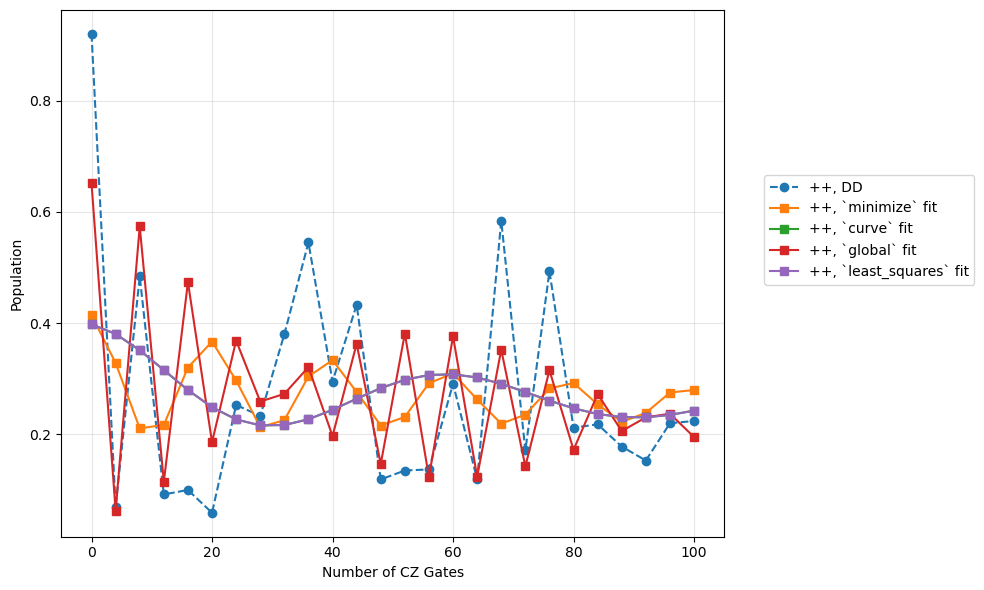

In [186]:
plt.figure(figsize=(10, 6))
plt.plot(n_cz, pop_00[Exp.DD_PP,:], marker='o', label='++, DD', linestyle='--')
plt.plot(n_cz, fit_curve_for_DD_PP_with_device_timescales(n_cz, *optim_params_minimize), marker='s', label='++, `minimize` fit')
if optim_params_curve is not None:
    plt.plot(n_cz, fit_curve_for_DD_PP_with_device_timescales(n_cz, *optim_params_curve), marker='s', label='++, `curve` fit')
plt.plot(n_cz, fit_curve_for_DD_PP_with_device_timescales(n_cz, *optim_params_global), marker='s', label='++, `global` fit')
plt.plot(n_cz, fit_curve_for_DD_PP_with_device_timescales(n_cz, *optim_params_squares), marker='s', label='++, `least_squares` fit')
plt.xlabel('Number of CZ Gates')
plt.ylabel('Population')
# plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 0.7), loc='upper left')
plt.tight_layout()
plt.show()


In [188]:
print(optim_params_global)

[0.09183833 0.19897664 0.03762885]


Same results as before. Then use any of the routines which make sense.

In [212]:
from typing import Callable

def extract_params(
    experiment : int, 
    n_cz : np.array, 
    fidelities : np.array, 
    initial_guess : np.array =None,
    use_global_search : bool=True,
    search_for_timescale : bool=True,
    fit_function: Callable=None
) -> dict:
    """
    use_global_search: use global optimization to find parameters
    search_for_timescale: whether to search for T1_1, T1_2, T2_1, T2_2 values for the qubits for the DD ++ experiment.
        If false, then a fit function needs to be supplied which has the timescales ingrained into the fit function
    fit_function: the function to be used in DD ++ experiment fits if `search_for_timescale` is False
        Example: 
        fit_curve_for_DD_PP_with_device_timescales = fit_curve_for_DD_PP_device_factory(tg_X, tg_cz, device_characteristics);
    """
    angle_bound = (-0.1, 0.1);
    timescale_bound = (10, 1000);
    if experiment == Exp.DD_0P:
        bounds = [timescale_bound, angle_bound, (0, 1), (0, 1)]; # decay_timescale, overrotation, spam, spam
        initial_guess = (300, 0.01, 1, 1) if initial_guess is None else initial_guess;
        if use_global_search:
            optim_params, residue, yy = fit_parameters_global_optimization(
                fit_curve_for_DD_0P, n_cz, fidelities, bounds = bounds);
        else:
            optim_params, residue, _ = fit_parameters_scipy_minimize(
                fit_curve_for_DD_0P, n_cz, fidelities, initial_guess, bounds = bounds);
        return {
            "plotting_params": optim_params,
            "residue": residue,
            "extracted_params": {
                "IZ": optim_params[1], # degrees overrotation per gate
                "T_D": optim_params[0], # microseconds
                "spam": optim_params[2:]
            }
        }
    elif experiment == Exp.DD_P0:
        bounds = [timescale_bound, angle_bound, (0, 1), (0, 1)]; # decay_timescale, overrotation, spam, spam
        initial_guess = (300, 0.01, 1, 1) if initial_guess is None else initial_guess;
        if use_global_search:
            optim_params, residue, yy = fit_parameters_global_optimization(
                fit_curve_for_DD_P0, n_cz, fidelities, bounds = bounds);
        else:
            optim_params, residue, _ = fit_parameters_scipy_minimize(
                fit_curve_for_DD_P0, n_cz, fidelities, initial_guess, bounds = bounds);
        return {
            "plotting_params": optim_params,
            "residue": residue,
            "extracted_params": {
                "ZI": optim_params[1], # degrees overrotation per gate
                "T_D": optim_params[0], # microseconds
                "spam": optim_params[2:]
            }
        }
    elif experiment == Exp.DD_PP:
        if not search_for_timescale:
            bounds = [angle_bound, (0, 1), (0, 1)]; # overrotation, spam, spam
            initial_guess = (0.01, 4/16, 1/16) if initial_guess is None else initial_guess;
            if use_global_search:
                optim_params, residue, _ = fit_parameters_global_optimization(
                    fit_function, n_cz, fidelities,
                    bounds = bounds);
            else:
                optim_params, residue, _ = fit_parameters_scipy_minimize(
                    fit_function, n_cz, fidelities, initial_guess,
                    bounds = bounds);
            return {
                "plotting_params": optim_params,
                "residue": residue,
                "extracted_params": {
                    "ZZ": optim_params[0], # degrees overrotation per gate
                    "spam": optim_params[1:]
                }
            }
        else:
            bounds = [angle_bound, (0, 1), (0, 1), timescale_bound, timescale_bound, timescale_bound, timescale_bound];
            initial_guess = (0.01, 4/16, 1/16, 300, 300, 300, 300) if initial_guess is None else initial_guess;
            if use_global_search:
                optim_params, residue, _ = fit_parameters_global_optimization(
                    fit_curve_for_DD_PP, n_cz, fidelities, bounds = bounds);
            else:
                optim_params, residue, _ = fit_parameters_scipy_minimize(
                    fit_curve_for_DD_PP, n_cz, fidelities, initial_guess, bounds = bounds);
            return {
                "plotting_params": optim_params,
                "residue": residue,
                "extracted_params": {
                    "ZZ": optim_params[0], # degrees overrotation per gate
                    "spam": optim_params[1:3],
                    "T1_1": optim_params[3],
                    "T1_2": optim_params[4],
                    "T2_1": optim_params[5],
                    "T2_2": optim_params[6]
                }
            }
    elif experiment == Exp.NO_DD_11:
        bounds = [timescale_bound, (0, 1), (0, 1)]
        initial_guess = (300, 0.5, 0.5) if initial_guess is None else initial_guess;
        if use_global_search:
            optim_params, residue, _ = fit_parameters_global_optimization(
                    fit_curve_for_No_DD_11, n_cz, fidelities, bounds = bounds);
        else:
            optim_params, residue, _ = fit_parameters_scipy_minimize(
                fit_curve_for_No_DD_11, n_cz, fidelities, initial_guess, bounds = bounds);
        return {
            "plotting_params": optim_params,
            "residue": residue,
            "extracted_params": {
                "T_D": optim_params[0], # microseconds
                "spam": optim_params[1:]
            }
        }
    elif experiment == Exp.PP:
        bounds = [angle_bound, angle_bound, angle_bound, (0, 1), (0, 1), timescale_bound, timescale_bound, timescale_bound, timescale_bound];
        initial_guess = (0.01, 0.01, 0.01, 4/16, 1/16, 300, 300, 300, 300) if initial_guess is None else initial_guess;
        if use_global_search:
            optim_params, residue, _ = fit_parameters_global_optimization(
                fit_curve_for_DD_PP, n_cz, fidelities, bounds = bounds);
        else:
            optim_params, residue, _ = fit_parameters_scipy_minimize(
                fit_curve_for_DD_PP, n_cz, fidelities, initial_guess, bounds = bounds);
        return {
            "plotting_params": optim_params,
            "residue": residue,
            "extracted_params": {
                "ZZ": optim_params[0], # degrees overrotation per gate
                "ZI": optim_params[1], # degrees overrotation per gate
                "IZ": optim_params[2], # degrees overrotation per gate
                "spam": optim_params[3:5],
                "T1_1": optim_params[5],
                "T1_2": optim_params[6],
                "T2_1": optim_params[7],
                "T2_2": optim_params[8]
            }
        }
    else:
        raise Exception("Cannot handle experiments other than DD on 0+, +0, ++ and no-DD on 11")

In [203]:
error = {"ZZ": 0.00, "ZI": 0, "IZ": 0.02};
device_characteristics = {"T1_1": T1_1, "T1_2": T1_2, "T2_1": T2_1, "T2_2": T2_2};
print("Actual error:", error)
print("Device characteristics:", device_characteristics)
print("Gate time", tg_X+tg_cz)
print("Decay timescale", T2_2/(tg_X+tg_cz))

y_data = ideal_curve_for_0P(n_cz, tg_X+tg_cz, device_characteristics, error)

result = extract_params(Exp.DD_0P, n_cz, y_data, use_global_search=True);
print("\nGlobal optimization")
print("Residue", result["residue"])
print("RMSE:", np.sum(np.abs(y_data - fit_curve_for_DD_0P(n_cz, *result["plotting_params"]))**2))
print("Extracted params: ", result["extracted_params"])

result = extract_params(Exp.DD_0P, n_cz, y_data, use_global_search=False);
print("\nDefault init, local search")
print("Residue", result["residue"])
print("RMSE:", np.sum(np.abs(y_data - fit_curve_for_DD_0P(n_cz, *result["plotting_params"]))))
print("Extracted params: ", result["extracted_params"])

result = extract_params(Exp.DD_0P, n_cz, y_data, use_global_search=False, initial_guess=(50/0.104, 0.02, 1, 1));
print("\nCheating init, local search")
print("Residue", result["residue"])
print("RMSE:", np.sum(np.abs(y_data - fit_curve_for_DD_0P(n_cz, *result["plotting_params"]))))
print("Extracted params: ", result["extracted_params"])


Actual error: {'ZZ': 0.0, 'ZI': 0, 'IZ': 0.02}
Device characteristics: {'T1_1': 50, 'T1_2': 25, 'T2_1': 40, 'T2_2': 50}
Gate time 0.10400000000000001
Decay timescale 480.7692307692307

Global optimization
Residue 5.655822964915467e-15
RMSE: 8.31696668672095e-28
Extracted params:  {'IZ': np.float64(0.019999999999999952), 'T_D': np.float64(480.76923076922156), 'spam': array([0.5, 0.5])}

Default init, local search
Residue 0.25368406274061545
RMSE: 5.7240263971856855
Extracted params:  {'IZ': np.float64(0.1), 'T_D': np.float64(299.9992667778395), 'spam': array([0.50356039, 0.03646806])}

Cheating init, local search
Residue 3.0937054636623263e-07
RMSE: 6.726188639616382e-06
Extracted params:  {'IZ': np.float64(0.019999997304467835), 'T_D': np.float64(480.7689799501319), 'spam': array([0.50000016, 0.49999996])}


# MIT Results

In [191]:
import numpy as np

folder = "Deterministic benchmarking result - modified"
n_cz = np.load(f"{folder}/num_cz_gates.npy");
pop_00 = np.load(f"{folder}/pop_00_vs_exp.npy");
pop_01 = np.load(f"{folder}/pop_01_vs_exp.npy");
pop_10 = np.load(f"{folder}/pop_10_vs_exp.npy");
pop_11 = np.load(f"{folder}/pop_11_vs_exp.npy");
pop_qb1 = np.load(f"{folder}/pop_QB1_vs_exp.npy");
pop_qb2 = np.load(f"{folder}/pop_QB2_vs_exp.npy");

T1_1 = 50; # microseconds
T1_2 = 25; # microseconds
T2_1 = 40; # microseconds
T2_2 = 4; # microseconds

tg_X = 0.030 + 0.010; # microseconds
tg_cz = 0.070 + 0.010; # microseconds

In [206]:
fit_params_0P = extract_params(Exp.DD_0P, n_cz, pop_00[Exp.DD_0P,:]);
fit_params_P0 = extract_params(Exp.DD_P0, n_cz, pop_00[Exp.DD_P0,:]);
fit_params_PP = extract_params(Exp.DD_PP, n_cz, pop_00[Exp.DD_PP,:]);

device_characteristics = {"T1_1": T1_1, "T1_2": T1_2, "T2_1": T2_1, "T2_2": T2_2};
fit_curve_for_DD_PP_with_device_timescales = fit_curve_for_DD_PP_device_factory(tg_X, tg_cz, device_characteristics);
fit_params_PP_device = extract_params(Exp.DD_PP, n_cz, pop_00[Exp.DD_PP,:],
    search_for_timescale=False,
    fit_function=fit_curve_for_DD_PP_with_device_timescales
    );

print("From 0+ experiment: ")
print(fit_params_0P["extracted_params"])
print()

print("From +0 experiment: ")
print(fit_params_P0["extracted_params"])
print()

print("From ++ experiment: ")
print(fit_params_PP["extracted_params"])
print(fit_params_PP_device["extracted_params"])

From 0+ experiment: 
{'IZ': np.float64(-0.005458832663652237), 'T_D': np.float64(232.56959549115908), 'spam': array([0.37891015, 0.57047059])}

From +0 experiment: 
{'ZI': np.float64(-0.005270657909421101), 'T_D': np.float64(182.13042296813742), 'spam': array([0.26131492, 0.70924529])}

From ++ experiment: 
{'ZZ': np.float64(-0.09186709562644815), 'spam': array([0.25273317, 0.05289157]), 'T1_1': np.float64(731.6530460890427), 'T1_2': np.float64(714.7916724020882), 'T2_1': np.float64(11.960207592764636), 'T2_2': np.float64(618.7302041790194)}
{'ZZ': np.float64(0.09183792426266654), 'spam': array([0.19939776, 0.03757635])}


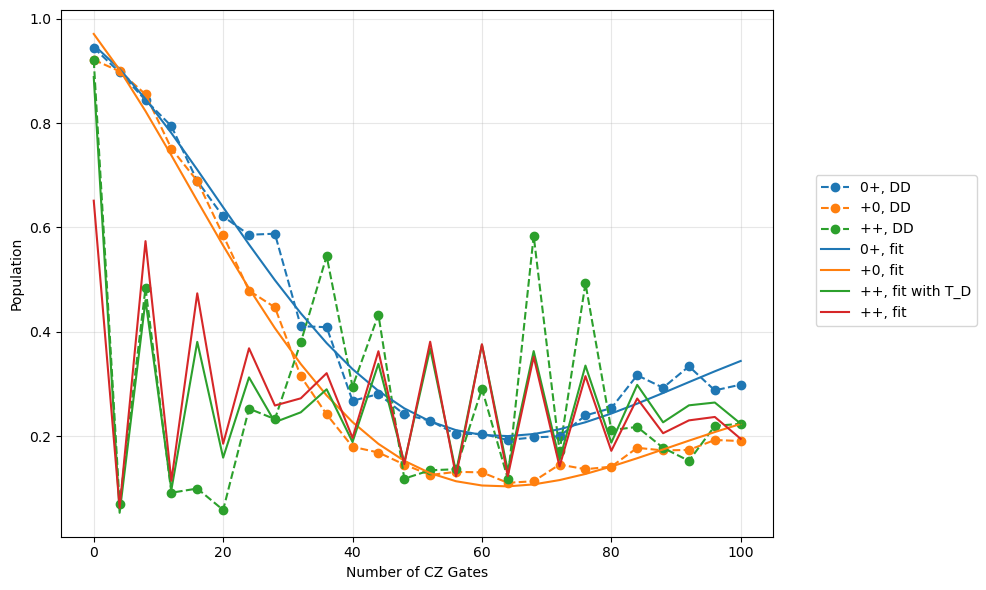

In [207]:
plt.figure(figsize=(10, 6))

# Define colors for each group (e.g., 3 colors for 3 groups)
colors = ['tab:blue', 'tab:orange', 'tab:green']

# Data curves
plt.plot(n_cz, pop_00[Exp.DD_0P,:], label='0+, DD', linestyle="--", marker='o', color=colors[0])
plt.plot(n_cz, pop_00[Exp.DD_P0,:], label='+0, DD', linestyle="--", marker='o', color=colors[1])
plt.plot(n_cz, pop_00[Exp.DD_PP,:], label='++, DD', linestyle="--", marker='o', color=colors[2])

# Fit curves (use the same color as the corresponding data curve)
t = n_cz;#np.linspace(0, n_cz[-1], int(n_cz[-1]))
plt.plot(t, fit_curve_for_DD_0P(t, *fit_params_0P["plotting_params"]), label='0+, fit', color=colors[0])
plt.plot(t, fit_curve_for_DD_P0(t, *fit_params_P0["plotting_params"]), label='+0, fit', color=colors[1])
plt.plot(t, fit_curve_for_DD_PP(t, *fit_params_PP["plotting_params"]), label='++, fit with T_D', color=colors[2])
plt.plot(t, fit_curve_for_DD_PP_with_device_timescales(t, *fit_params_PP_device["plotting_params"]), label='++, fit', color='tab:red')

plt.xlabel('Number of CZ Gates')
plt.ylabel('Population')

plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 0.7), loc='upper left')
plt.tight_layout()
plt.show()

# IBM results

## Extract raw data

In [194]:
measurement_points=np.arange(0,102,4)
state_list=['00','01','0+','+0','++']
qubit_list=[
    [21,22],
]
UR_list=['None','Both','0','1']
experiment_date = '06-01-25-CZ'

In [195]:
import json

circuit_list={}
for ur in UR_list:
    ur_key=f'{ur}'
    # …later, load it back
    with open(f'fitting-saurav/circuit_list_{ur_key}_{experiment_date}.json', 'r') as f:
        circuit_list[ur_key] = json.load(f)

In [196]:
import os

# Example inputs; these should already be defined in your context:
# UR_list = [...]
# circuit_list = { ur_key: [exp1, exp2, ...], ... }
# experiment_date = "2025-06-20"  # for example, or however you define it
base_dir = os.getcwd()
add_dir = "fitting-saurav"
res_dic = {}

for ur_key in UR_list:
    # Construct the directory where results were saved for this UR
    dir_path = os.path.join(base_dir, add_dir, experiment_date, ur_key)
    if not os.path.isdir(dir_path):
        # Handle missing directory as appropriate: you may skip or raise an error.
        raise FileNotFoundError(f"Expected directory not found: {dir_path}")
    
    # For possible per-UR grouping if desired
    res_dic_save = {}
    
    for exp in circuit_list.get(ur_key, []):
        filename = f"results-{exp}.json"
        file_path = os.path.join(dir_path, filename)
        
        if not os.path.isfile(file_path):
            # Handle missing file: skip, warn, or raise
            raise FileNotFoundError(f"Expected file not found: {file_path}")
        
        with open(file_path, "r") as f:
            counts = json.load(f)
        
        # Store in the per-UR dictionary
        res_dic_save[exp] = counts
        
        # Store in the global flat dictionary, matching your saving key
        res_dic[f"{ur_key}-{exp}"] = counts
    
    # If you wish to keep a mapping per UR, you can store res_dic_save:
    # per_UR_results[ur_key] = res_dic_save
    # (Define per_UR_results = {} before the loop if needed.)

In [197]:
import math

def fid_CT(counts_in):
    """
    From a dict of 2-bit measurement counts, compute:
      - counts_00: raw shots where the outcome is '00'
      - p_00:      probability of '00'
      - sigma_00:  binomial std. deviation of p_00
    Returns (p_00, sigma_00, counts_00).
    """
    total_counts = sum(counts_in.values())
    if total_counts == 0:
        raise ValueError("No counts provided (sum is zero).")

    # Raw count for exactly '00'
    counts_00 = counts_in.get('00', 0)

    # Probability and its binomial σ
    p_00 = counts_00 / total_counts
    sigma_00 = math.sqrt(p_00 * (1 - p_00) / total_counts)

    return p_00, sigma_00


In [198]:
# assume fid_CT and fid_GHZ are already defined, and res_dic is your input dict

fid = {}
err = {}

for key, counts in res_dic.items():
        p, sigma = fid_CT(counts)
        fid[key] = p
        err[key] = sigma

# now fid and err hold your probabilities and uncertainties, e.g.
print(fid)
print(err)


{'None-00-0': 0.997, 'None-01-0': 0.9975, 'None-0+-0': 0.997, 'None-+0-0': 0.993, 'None-++-0': 0.994, 'None-00-4': 0.998, 'None-01-4': 0.995, 'None-0+-4': 0.978, 'None-+0-4': 0.946, 'None-++-4': 0.9395, 'None-00-8': 0.9975, 'None-01-8': 0.9855, 'None-0+-8': 0.959, 'None-+0-8': 0.8865, 'None-++-8': 0.886, 'None-00-12': 0.9985, 'None-01-12': 0.986, 'None-0+-12': 0.9445, 'None-+0-12': 0.79, 'None-++-12': 0.791, 'None-00-16': 0.999, 'None-01-16': 0.985, 'None-0+-16': 0.949, 'None-+0-16': 0.6765, 'None-++-16': 0.7275, 'None-00-20': 0.9965, 'None-01-20': 0.982, 'None-0+-20': 0.9305, 'None-+0-20': 0.5685, 'None-++-20': 0.6405, 'None-00-24': 0.9965, 'None-01-24': 0.976, 'None-0+-24': 0.902, 'None-+0-24': 0.4395, 'None-++-24': 0.5505, 'None-00-28': 0.9985, 'None-01-28': 0.9715, 'None-0+-28': 0.8935, 'None-+0-28': 0.3385, 'None-++-28': 0.4565, 'None-00-32': 0.999, 'None-01-32': 0.9685, 'None-0+-32': 0.888, 'None-+0-32': 0.213, 'None-++-32': 0.36, 'None-00-36': 0.9965, 'None-01-36': 0.9655, 'None

## Extracting fit parameters

In [199]:
for ur in UR_list:
    for state in state_list:
        # Prepare data arrays
        t_data = np.array(measurement_points, dtype=float)
        y_data = np.array([fid[f'{ur}-{state}-{mp}'] for mp in measurement_points], dtype=float)
        y_err  = np.array([err[f'{ur}-{state}-{mp}'] for mp in measurement_points], dtype=float)
        
        

In [200]:
T1_1 = 50; # microseconds
T1_2 = 25; # microseconds
T2_1 = 40; # microseconds
T2_2 = 50; # microseconds

tg_X = 0.036; # microseconds
tg_cz = 0.068; # microseconds

In [204]:
t_data = np.array(measurement_points, dtype=float)


ur, state = '1', '+0'
y_data = np.array([fid[f'{ur}-{state}-{mp}'] for mp in measurement_points], dtype=float)
fit_params_P0 = extract_params(Exp.DD_P0, t_data, y_data);

ur, state = 'Both', '++'
y_data = np.array([fid[f'{ur}-{state}-{mp}'] for mp in measurement_points], dtype=float)
fit_params_PP = extract_params(Exp.DD_PP, t_data, y_data);

print("From 0+ experiment: ")
print(fit_params_0P["extracted_params"])
print()

print("From +0 experiment: ")
print(fit_params_P0["extracted_params"])
print()

print("From ++ experiment: ")
print(fit_params_PP["extracted_params"])

From 0+ experiment: 
{'IZ': np.float64(0.0005485490609002152), 'T_D': np.float64(638.021261516729), 'spam': array([0.00146656, 0.98330814])}

From +0 experiment: 
{'ZI': np.float64(-0.0018108737036094287), 'T_D': np.float64(472.15170663893804), 'spam': array([0.40863639, 0.58207751])}

From ++ experiment: 
{'ZZ': np.float64(-0.0010805290486578967), 'spam': array([0.61178054, 0.03196973]), 'T1_1': np.float64(51.68625704669373), 'T1_2': np.float64(989.6081829885372), 'T2_1': np.float64(957.5775386461322), 'T2_2': np.float64(617.1549283121135)}


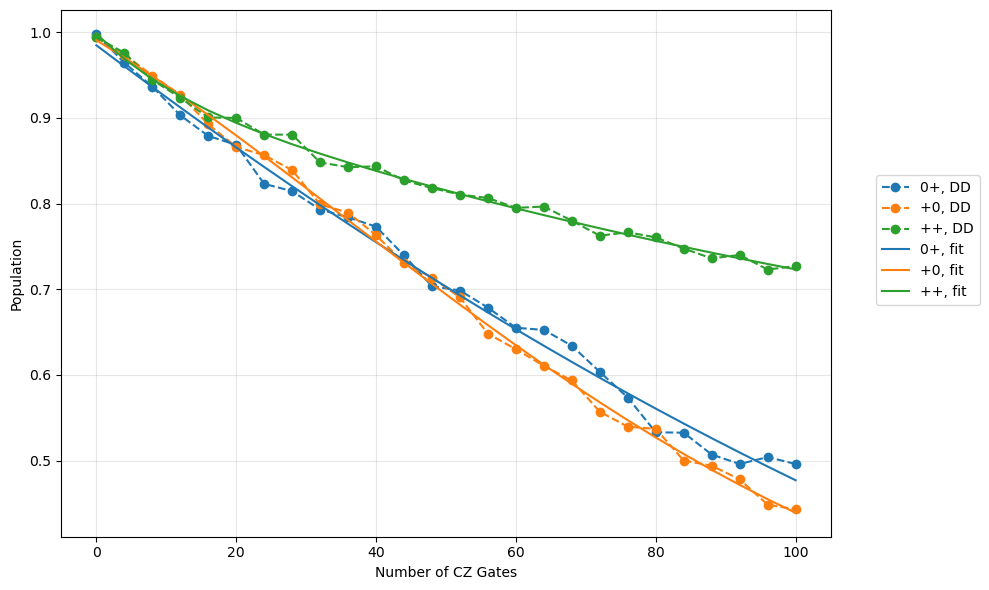

In [205]:
plt.figure(figsize=(10, 6))

# Define colors for each group (e.g., 3 colors for 3 groups)
colors = ['tab:blue', 'tab:orange', 'tab:green']

# Data curves
ur, state = '0', '0+'
y_data = np.array([fid[f'{ur}-{state}-{mp}'] for mp in measurement_points], dtype=float)
plt.plot(t_data, y_data, label='0+, DD', linestyle="--", marker='o', color=colors[0])

ur, state = '1', '+0'
y_data = np.array([fid[f'{ur}-{state}-{mp}'] for mp in measurement_points], dtype=float)
plt.plot(t_data, y_data, label='+0, DD', linestyle="--", marker='o', color=colors[1])

ur, state = 'Both', '++'
y_data = np.array([fid[f'{ur}-{state}-{mp}'] for mp in measurement_points], dtype=float)
plt.plot(t_data, y_data, label='++, DD', linestyle="--", marker='o', color=colors[2])

# Fit curves (use the same color as the corresponding data curve)
t = t_data; #np.linspace(0, t_data[-1], int(t_data[-1]))
plt.plot(t, fit_curve_for_DD_0P(t, *fit_params_0P["plotting_params"]), label='0+, fit', color=colors[0])
plt.plot(t, fit_curve_for_DD_P0(t, *fit_params_P0["plotting_params"]), label='+0, fit', color=colors[1])
plt.plot(t, fit_curve_for_DD_PP(t, *fit_params_PP["plotting_params"]), label='++, fit', color=colors[2])

plt.xlabel('Number of CZ Gates')
plt.ylabel('Population')

plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 0.7), loc='upper left')
plt.tight_layout()
plt.show()

In [213]:
print(UR_list)

['None', 'Both', '0', '1']


In [ ]:
t_data = np.array(measurement_points, dtype=float)

for ur in UR_list:
    for state in state_list:
        y_data = np.array([fid[f'{ur}-{state}-{mp}'] for mp in measurement_points], dtype=float)
        if state in ['0+', '+0']:
            fit_params = extract_params(Exp.DD_P0, t_data, y_data);
            plt.plot()
        elif state in ['++']:
            if ur == 'None':
                fit_params = extract_params(Exp.PP, t_data, y_data);
            if ur == 'None':
                fit_params = extract_params(Exp.PP, t_data, y_data);
        print(fit_params_0P)

ur, state = '1', '+0'

ur, state = 'Both', '++'
y_data = np.array([fid[f'{ur}-{state}-{mp}'] for mp in measurement_points], dtype=float)
fit_params_PP = extract_params(Exp.DD_PP, t_data, y_data);

print("From 0+ experiment: ")
print(fit_params_0P["extracted_params"])
print()

print("From +0 experiment: ")
print(fit_params_P0["extracted_params"])
print()

print("From ++ experiment: ")
print(fit_params_PP["extracted_params"])